# Naïve Bayes Classification: Fake News Detection

**Objective:** This project aims to develop a Naive Bayes classifier to distinguish between "REAL" and "FAKE" news articles. We will use the provided `Assignment_Data_fake_or_real_news.csv` dataset and follow a structured machine learning workflow, enhancing upon a basic spam detection demo. The focus will be on clear preprocessing, robust modeling, thorough evaluation, and professional presentation with modern, dark-themed visualizations.

**Dataset:** `Assignment_Data_fake_or_real_news.csv` containing news titles, text, and labels.

**Core Steps:**
1.  **Setup & Libraries:** Importing necessary tools.
2.  **Load Data:** Reading the news dataset.
3.  **Initial Data Exploration & Preprocessing:** Understanding the data, handling missing values, encoding the target variable, and advanced text cleaning (lowercase, punctuation/number removal, stopword removal, lemmatization).
4.  **Train-Test Split:** Dividing data for model training and evaluation.
5.  **Feature Extraction & Model Training:**
    * Applying `CountVectorizer` (Bag of Words).
    * Applying `TfidfVectorizer` for improved feature representation.
    * Training `MultinomialNB` and `ComplementNB` classifiers.
6.  **Model Evaluation:** Assessing model performance using accuracy, classification reports, and confusion matrices.
7.  **Prediction on New Data:** Demonstrating how to use the trained model.
8.  **Conclusion & Further Improvements:** Summarizing findings and suggesting future work.

In [17]:
# ## 1. Setup & Libraries

# ### Import Core Libraries
import pandas as pd
import numpy as np
import re
import string
from tqdm.notebook import tqdm # For progress bars (if running in a notebook that supports it)
# If tqdm.notebook doesn't work, use from tqdm import tqdm

# ### Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ### Import NLTK for Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK resources if not already present (run once)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    word_tokenize("example")
except LookupError:
    nltk.download('punkt')
try:
    WordNetLemmatizer().lemmatize("cats")
except LookupError:
    nltk.download('wordnet')
# Optional: averaged_perceptron_tagger for more advanced lemmatization (if using POS tags)
# try:
#     nltk.pos_tag(word_tokenize("example"))
# except LookupError:
#     nltk.download('averaged_perceptron_tagger')


# ### Import Scikit-learn Modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB # BernoulliNB can also be tried
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # roc_curve, auc can be added for detailed eval
from sklearn.preprocessing import LabelEncoder

# ### Configure Visualizations for Dark Theme
plt.style.use('dark_background')
# Modern color palette for dark backgrounds
modern_palette_dark_vibrant = ["#2ECC71", "#E74C3C", "#3498DB", "#F1C40F", "#9B59B6", "#34495E", "#1ABC9C"]
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.facecolor'] = '#2B2B2B'
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
plt.rcParams['axes.labelcolor'] = '#E0E0E0'
plt.rcParams['xtick.color'] = '#E0E0E0'
plt.rcParams['ytick.color'] = '#E0E0E0'
plt.rcParams['grid.color'] = '#444444'
plt.rcParams['text.color'] = '#E0E0E0'
plt.rcParams['figure.facecolor'] = '#1E1E1E'
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
sns.set_palette(modern_palette_dark_vibrant)

# Initialize tqdm for pandas
tqdm.pandas()

print("Libraries imported and dark theme visual style configured.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Libraries imported and dark theme visual style configured.


## 2. Load Data
Let's load the `Assignment_Data_fake_or_real_news.csv` dataset.

In [18]:
# Load the dataset
df = pd.read_csv('Assignment_Data_fake_or_real_news.csv')

## 3. Initial Data Exploration & Preprocessing
First, we'll get an overview of the dataset, check for missing values, and perform necessary cleaning and transformations.

In [19]:
print("\n--- First 5 Rows ---")
df.head()


--- First 5 Rows ---


,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [20]:
print("\n--- Dataset Info ---")
df.info()


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [21]:
# Drop the first unnamed column if it exists (often an index from CSV saving)
if df.columns[0].startswith('Unnamed:'):
    df = df.drop(df.columns[0], axis=1)
    print("\nDropped the initial unnamed index column.")
    print(f"New shape after dropping index: {df.shape}")

In [22]:
print("\n--- Missing Values (Before Handling) ---")
print(df.isnull().sum())


--- Missing Values (Before Handling) ---
id       0
title    0
text     0
label    0
dtype: int64


In [23]:
# Combine Title and Text for a richer feature
df['full_text'] = df['title'] + " " + df['text']
print("\nCreated 'full_text' by combining 'title' and 'text'.")


Created 'full_text' by combining 'title' and 'text'.


In [24]:
# Move the 'label' column to the end
df = df[[col for col in df.columns if col != 'label'] + ['label']]

In [25]:
# Updated Dataframe
df.head()

,id,title,text,full_text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy U....,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...,FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...,REAL


## 4. Target Variable Exploration & Encoding
Understanding the distribution of our target variable ('label') and converting it to a numerical format suitable for machine learning models. We will map 'FAKE' to 1 and 'REAL' to 0 for intuitive interpretation (1 often represents the "positive" or "target" class in binary classification, like "spam" or, in this case, "fake").

In [26]:
print("\n--- Target Variable Distribution ('label') ---")
label_counts = df['label'].value_counts()
print(label_counts)


--- Target Variable Distribution ('label') ---
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


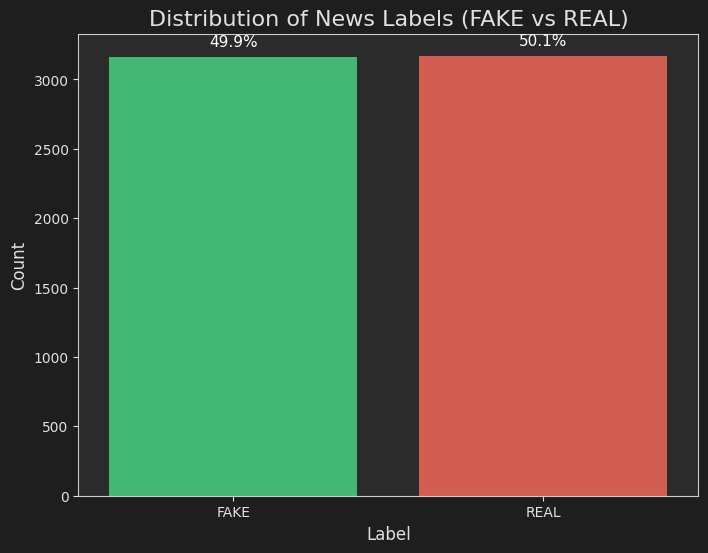

In [27]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette=[modern_palette_dark_vibrant[0], modern_palette_dark_vibrant[1]])
plt.title('Distribution of News Labels (FAKE vs REAL)', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
total = len(df['label'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x_coord = p.get_x() + p.get_width() / 2
    y_coord = p.get_height()
    ax.annotate(percentage, (x_coord, y_coord), ha='center', va='bottom', fontsize=11, color='white', xytext=(0,5), textcoords='offset points')
plt.show()

In [28]:
# Encode target variable: FAKE -> 1, REAL -> 0
# Using an explicit map for clarity and control over encoding
label_mapping = {'FAKE': 1, 'REAL': 0}
df['label_encoded'] = df['label'].map(label_mapping)

In [29]:
# Verify encoding
print("\nEncoded 'label' to 'label_encoded' (FAKE=1, REAL=0).")
print(df[['label', 'label_encoded']].value_counts())


Encoded 'label' to 'label_encoded' (FAKE=1, REAL=0).
label  label_encoded
REAL   0                3171
FAKE   1                3164
Name: count, dtype: int64


In [30]:
df.head()

,id,title,text,full_text,label,label_encoded
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE,1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy U....,REAL,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...,FAKE,1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...,REAL,0


## 5. Text Preprocessing
To prepare the text data for our Naive Bayes model, we'll perform several preprocessing steps:
- Convert text to lowercase.
- Remove punctuation.
- Remove numbers (optional, but common for general text classification unless numbers carry specific meaning).
- Tokenize the text into individual words.
- Remove common English stopwords.
- Apply lemmatization to reduce words to their base or dictionary form. Stemming is an alternative that could also be considered.

In [31]:
stop_words = set(stopwords.words('english'))
# Add custom stopwords if needed, e.g., common but irrelevant words in news
custom_stopwords = ['said', 'also', 'would', 'could', 'like', 'one', 'two', 'year', 'told']
stop_words.update(custom_stopwords)

lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer() # Alternative

def preprocess_text_advanced(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and # signs
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    # Consider part-of-speech tagging for more accurate lemmatization if needed
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2 and word.isalpha()]
    return " ".join(processed_words)

In [32]:
try:
    # Download punkt_tab as suggested by the error message
    nltk.data.find('tokenizers/punkt_tab/english/')
except LookupError:
    nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [33]:
print("\nApplying advanced text preprocessing to 'full_text'...")
df['processed_text'] = df['full_text'].progress_apply(preprocess_text_advanced)

print("\n--- Sample of Processed Text ---")
for i in range(3):
    print(f"\nOriginal [{df['label'].iloc[i]}]:\n{df['full_text'].iloc[i][:300]}...")
    print(f"\nProcessed [{df['label'].iloc[i]}]:\n{df['processed_text'].iloc[i][:300]}...")


Applying advanced text preprocessing to 'full_text'...


  0%|          | 0/6335 [00:00<?, ?it/s]


--- Sample of Processed Text ---

Original [FAKE]:
You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often th...

Processed [FAKE]:
smell hillary fear daniel greenfield shillman journalism fellow freedom center new york writer focusing radical islam final stretch election hillary rodham clinton gone war fbi word unprecedented thrown around often election ought retired still unprecedented nominee major political party war fbi exa...

Original [FAKE]:
Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO) Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr 
There are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. T...

## 6. Word Clouds for Visual Exploration
Word clouds can give us a quick visual sense of the most frequent words in real vs. fake news, which might highlight differentiating terms after preprocessing.

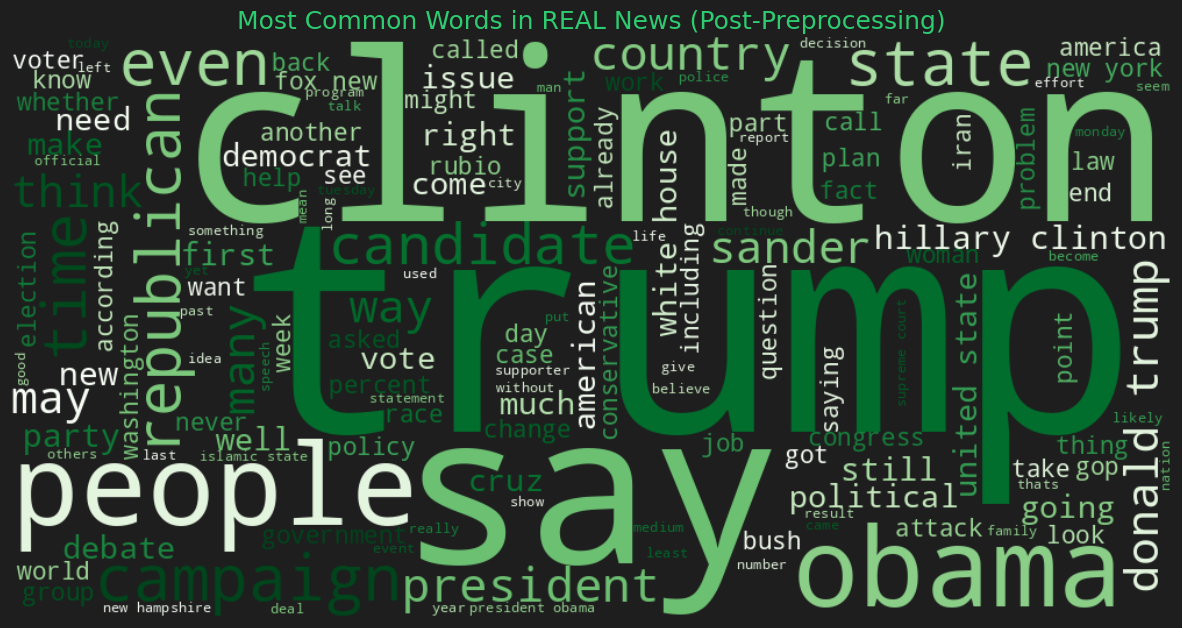

In [34]:
# Word cloud for REAL news
real_news_text_wc = " ".join(df[df['label_encoded'] == 0]['processed_text'])
if real_news_text_wc.strip(): # Check if string is not empty
    wordcloud_real = WordCloud(width=1000, height=500, background_color='#1E1E1E',
                               colormap='Greens', max_words=150, contour_width=1, contour_color='green').generate(real_news_text_wc)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in REAL News (Post-Preprocessing)', fontsize=18, color=modern_palette_dark_vibrant[0])
    plt.show()
else:
    print("No text available for REAL news word cloud after preprocessing.")

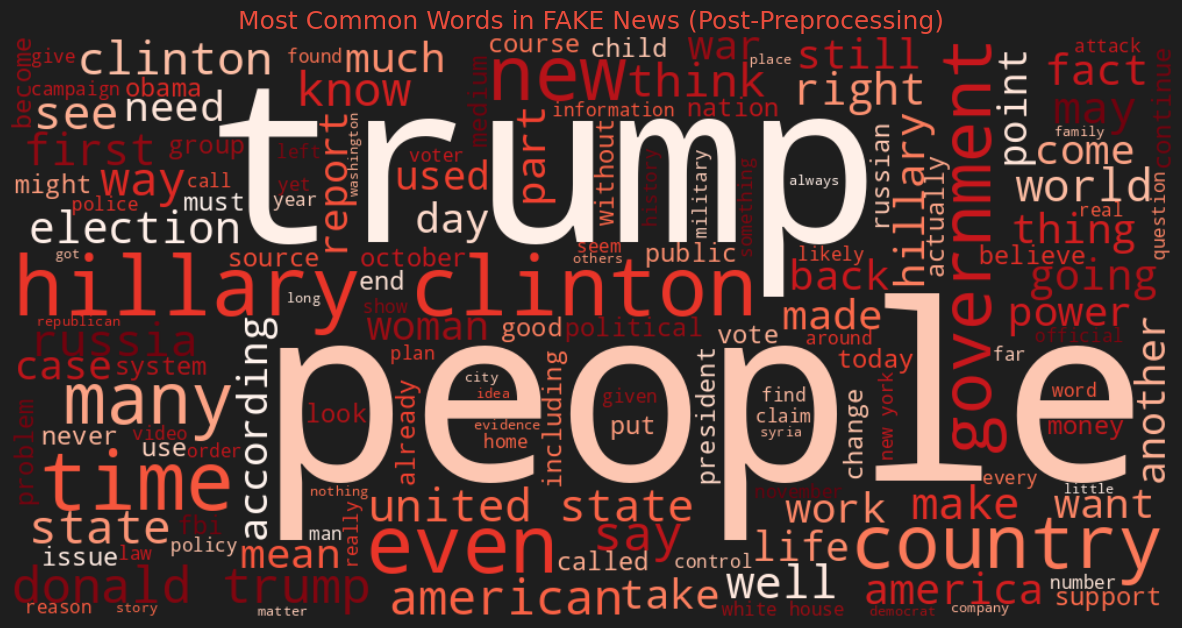

In [35]:
# Word cloud for FAKE news
fake_news_text_wc = " ".join(df[df['label_encoded'] == 1]['processed_text'])
if fake_news_text_wc.strip(): # Check if string is not empty
    wordcloud_fake = WordCloud(width=1000, height=500, background_color='#1E1E1E',
                               colormap='Reds', max_words=150, contour_width=1, contour_color='red').generate(fake_news_text_wc)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_fake, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in FAKE News (Post-Preprocessing)', fontsize=18, color=modern_palette_dark_vibrant[1])
    plt.show()
else:
    print("No text available for FAKE news word cloud after preprocessing.")

## 7. Train-Test Split
We'll split our dataset into training and testing sets to evaluate the model's performance on unseen data. The `processed_text` will be our feature (X) and `label_encoded` will be our target (y).

In [36]:
X = df['processed_text']
y = df['label_encoded']

# Stratify y to ensure similar class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [37]:
print(f"\nShapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"\nTraining set label distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set label distribution:\n{y_test.value_counts(normalize=True)}")


Shapes: X_train: (4751,), X_test: (1584,), y_train: (4751,), y_test: (1584,)

Training set label distribution:
label_encoded
0    0.500526
1    0.499474
Name: proportion, dtype: float64
Test set label distribution:
label_encoded
0    0.500631
1    0.499369
Name: proportion, dtype: float64


## 8. Feature Extraction (Vectorization) & Model Training
Text data needs to be converted into a numerical format that machine learning models can understand. We'll use two common techniques:
- **CountVectorizer:** Creates a matrix based on the frequency of each word (Bag of Words).
- **TfidfVectorizer:** Considers Term Frequency-Inverse Document Frequency, which gives higher weight to words that are frequent in a document but rare across the entire corpus.

We will then train Naive Bayes models (MultinomialNB and ComplementNB) using these vectorized features. A pipeline will be used to streamline the vectorization and classification steps.

### 8.1. Naive Bayes with CountVectorizer (Bag of Words)
First, let's try the Multinomial Naive Bayes classifier with features generated by `CountVectorizer`. We'll use n-grams (1,2) to capture some word pairs and set `max_df` to ignore terms that are too frequent across documents. Alpha is added for Laplace smoothing.

In [38]:
print("\n--- Training Naive Bayes with CountVectorizer ---")

# Define parameters for CountVectorizer
cv_params = {
    'ngram_range': (1, 2),     # Consider unigrams and bigrams
    'stop_words': 'english',   # Remove English stopwords (can be redundant if already done in preprocessing)
    'max_df': 0.7,             # Ignore terms that appear in more than 70% of documents
    'min_df': 3,               # Ignore terms that appear in less than 3 documents
    'max_features': None       # Consider all features (or set a limit like 10000)
}

# Define parameters for MultinomialNB
nb_params = {'alpha': 0.1} # Laplace smoothing parameter

pipeline_cv_multinomial = Pipeline([
    ('vectorizer', CountVectorizer(**cv_params)),
    ('classifier', MultinomialNB(**nb_params))
])

pipeline_cv_multinomial.fit(X_train, y_train)
y_pred_cv_multinomial = pipeline_cv_multinomial.predict(X_test)
y_proba_cv_multinomial = pipeline_cv_multinomial.predict_proba(X_test)[:, 1] # Probabilities for ROC


--- Training Naive Bayes with CountVectorizer ---


In [39]:
# Evaluation
accuracy_cv_multinomial = accuracy_score(y_test, y_pred_cv_multinomial)
print(f"\nMultinomialNB with CountVectorizer - Accuracy: {accuracy_cv_multinomial:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cv_multinomial, target_names=['REAL (0)', 'FAKE (1)']))


MultinomialNB with CountVectorizer - Accuracy: 0.9167

Classification Report:
              precision    recall  f1-score   support

    REAL (0)       0.90      0.94      0.92       793
    FAKE (1)       0.94      0.89      0.91       791

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584



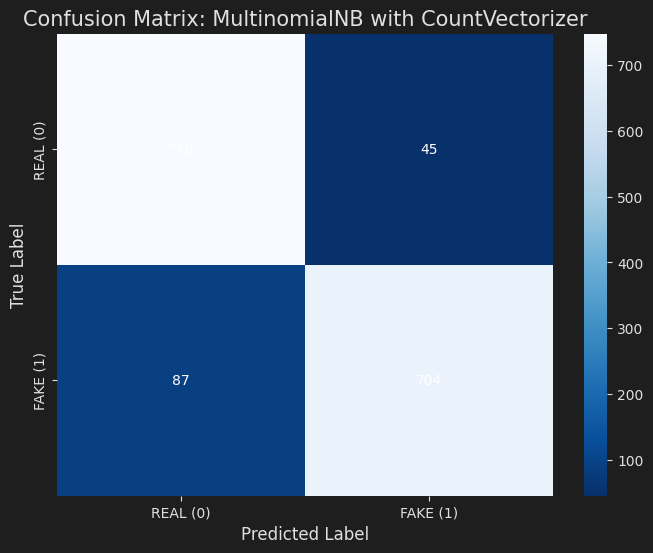

In [40]:
# Confusion Matrix
cm_cv_multinomial = confusion_matrix(y_test, y_pred_cv_multinomial)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv_multinomial, annot=True, fmt='d', cmap='Blues_r', # Dark-friendly cmap
            xticklabels=['REAL (0)', 'FAKE (1)'], yticklabels=['REAL (0)', 'FAKE (1)'],
            annot_kws={"color": "white" if cm_cv_multinomial.max() > np.percentile(cm_cv_multinomial, 75) else "black"})
plt.title('Confusion Matrix: MultinomialNB with CountVectorizer', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

### 8.2. Naive Bayes with TfidfVectorizer
Next, we'll use `TfidfVectorizer`, which often yields better results for text classification tasks as it accounts for term importance.

In [55]:
print("\n--- Training Naive Bayes with TfidfVectorizer ---")

# Define parameters for TfidfVectorizer
tfidf_params = {
    'ngram_range': (1, 2),
    'stop_words': 'english',
    'max_df': 0.7,
    'min_df': 3,
    'use_idf': True,
    'smooth_idf': True,
    'sublinear_tf': True, # Apply sublinear tf scaling
    'max_features': None
}

pipeline_tfidf_multinomial = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_params)),
    ('classifier', MultinomialNB(**nb_params)) # Using same NB params
])

pipeline_tfidf_multinomial.fit(X_train, y_train)
y_pred_tfidf_multinomial = pipeline_tfidf_multinomial.predict(X_test)
y_proba_tfidf_multinomial = pipeline_tfidf_multinomial.predict_proba(X_test)[:, 1]


--- Training Naive Bayes with TfidfVectorizer ---


In [56]:
# Evaluation
accuracy_tfidf_multinomial = accuracy_score(y_test, y_pred_tfidf_multinomial)
print(f"\nMultinomialNB with TfidfVectorizer - Accuracy: {accuracy_tfidf_multinomial:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_multinomial, target_names=['REAL (0)', 'FAKE (1)']))


MultinomialNB with TfidfVectorizer - Accuracy: 0.9179

Classification Report:
              precision    recall  f1-score   support

    REAL (0)       0.91      0.93      0.92       793
    FAKE (1)       0.93      0.90      0.92       791

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584



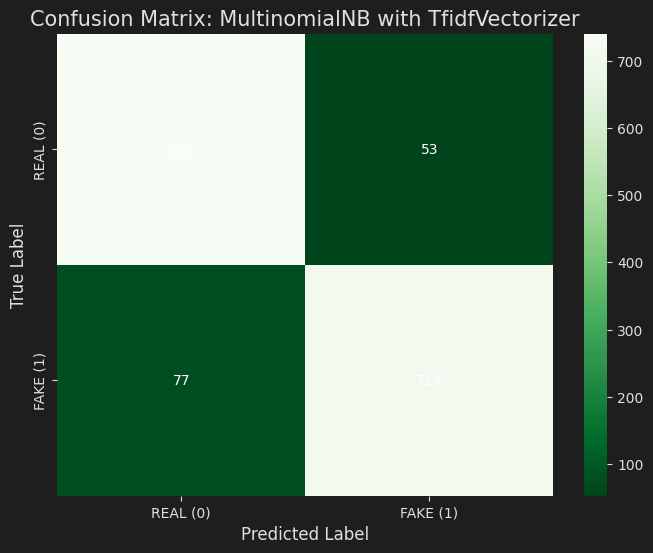

In [57]:
# Confusion Matrix
cm_tfidf_multinomial = confusion_matrix(y_test, y_pred_tfidf_multinomial)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf_multinomial, annot=True, fmt='d', cmap='Greens_r',
            xticklabels=['REAL (0)', 'FAKE (1)'], yticklabels=['REAL (0)', 'FAKE (1)'],
            annot_kws={"color": "white" if cm_tfidf_multinomial.max() > np.percentile(cm_tfidf_multinomial, 75) else "black"})
plt.title('Confusion Matrix: MultinomialNB with TfidfVectorizer', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

### 8.3. Complement Naive Bayes with TfidfVectorizer
Complement Naive Bayes (CNB) is an adaptation of Multinomial Naive Bayes (MNB) that is particularly suited for imbalanced datasets, although it often performs well on balanced text datasets too.

In [58]:
print("\n--- Training Complement Naive Bayes with TfidfVectorizer ---")
# Using same TfidfVectorizer params
# Define parameters for ComplementNB
cnb_params = {'alpha': 0.1, 'norm': True} # norm=True can sometimes help

pipeline_tfidf_complement = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_params)),
    ('classifier', ComplementNB(**cnb_params))
])

pipeline_tfidf_complement.fit(X_train, y_train)
y_pred_tfidf_complement = pipeline_tfidf_complement.predict(X_test)
y_proba_tfidf_complement = pipeline_tfidf_complement.predict_proba(X_test)[:, 1]


--- Training Complement Naive Bayes with TfidfVectorizer ---


In [59]:
# Evaluation
accuracy_tfidf_complement = accuracy_score(y_test, y_pred_tfidf_complement)
print(f"\nComplementNB with TfidfVectorizer - Accuracy: {accuracy_tfidf_complement:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_complement, target_names=['REAL (0)', 'FAKE (1)']))


ComplementNB with TfidfVectorizer - Accuracy: 0.9186

Classification Report:
              precision    recall  f1-score   support

    REAL (0)       0.89      0.95      0.92       793
    FAKE (1)       0.95      0.88      0.92       791

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584



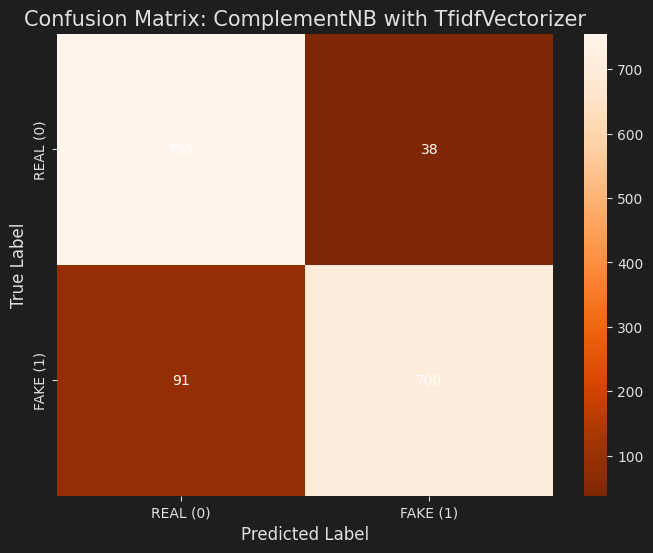

In [60]:
# Confusion Matrix
cm_tfidf_complement = confusion_matrix(y_test, y_pred_tfidf_complement)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf_complement, annot=True, fmt='d', cmap='Oranges_r',
            xticklabels=['REAL (0)', 'FAKE (1)'], yticklabels=['REAL (0)', 'FAKE (1)'],
            annot_kws={"color": "white" if cm_tfidf_complement.max() > np.percentile(cm_tfidf_complement, 75) else "black"})
plt.title('Confusion Matrix: ComplementNB with TfidfVectorizer', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

## 9. Model Comparison & ROC Curve

Let's compare the performance of the different models and visualize their ROC curves.

In [61]:
print("\n--- Model Performance Summary ---")
results_summary = pd.DataFrame({
    'Model': ['MNB + CountVectorizer', 'MNB + TfidfVectorizer', 'CNB + TfidfVectorizer'],
    'Accuracy': [accuracy_cv_multinomial, accuracy_tfidf_multinomial, accuracy_tfidf_complement]
})
print(results_summary.sort_values(by='Accuracy', ascending=False))



--- Model Performance Summary ---
                   Model  Accuracy
2  CNB + TfidfVectorizer  0.918561
1  MNB + TfidfVectorizer  0.917929
0  MNB + CountVectorizer  0.916667


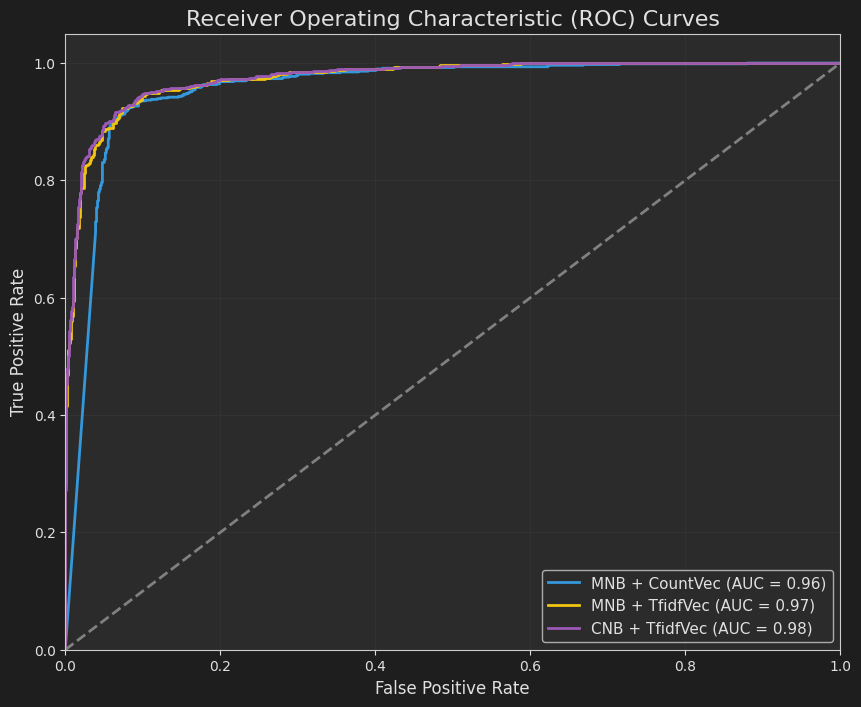


Discussion:
The TF-IDF Vectorizer generally provides better performance than simple CountVectorizer because it weights terms by their importance.
ComplementNB often performs well for text classification and might outperform MultinomialNB, especially if there's class imbalance (though our classes are fairly balanced).
The ROC AUC scores give a good measure of the models' ability to distinguish between REAL and FAKE news across different thresholds.


In [68]:
# ROC Curve
plt.figure(figsize=(10, 8))

# MNB with CountVectorizer
fpr_cv_mnb, tpr_cv_mnb, _ = roc_curve(y_test, y_proba_cv_multinomial)
roc_auc_cv_mnb = auc(fpr_cv_mnb, tpr_cv_mnb)
plt.plot(fpr_cv_mnb, tpr_cv_mnb, color=modern_palette_dark_vibrant[2], lw=2,
         label=f'MNB + CountVec (AUC = {roc_auc_cv_mnb:.2f})')

# MNB with TfidfVectorizer
fpr_tfidf_mnb, tpr_tfidf_mnb, _ = roc_curve(y_test, y_proba_tfidf_multinomial)
roc_auc_tfidf_mnb = auc(fpr_tfidf_mnb, tpr_tfidf_mnb)
plt.plot(fpr_tfidf_mnb, tpr_tfidf_mnb, color=modern_palette_dark_vibrant[3], lw=2,
         label=f'MNB + TfidfVec (AUC = {roc_auc_tfidf_mnb:.2f})')

# CNB with TfidfVectorizer
fpr_tfidf_cnb, tpr_tfidf_cnb, _ = roc_curve(y_test, y_proba_tfidf_complement)
roc_auc_tfidf_cnb = auc(fpr_tfidf_cnb, tpr_tfidf_cnb)
plt.plot(fpr_tfidf_cnb, tpr_tfidf_cnb, color=modern_palette_dark_vibrant[4], lw=2,
         label=f'CNB + TfidfVec (AUC = {roc_auc_tfidf_cnb:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("\nDiscussion:")
print("The TF-IDF Vectorizer generally provides better performance than simple CountVectorizer because it weights terms by their importance.")
print("ComplementNB often performs well for text classification and might outperform MultinomialNB, especially if there's class imbalance (though our classes are fairly balanced).")
print("The ROC AUC scores give a good measure of the models' ability to distinguish between REAL and FAKE news across different thresholds.")

10## 7. Prediction on New Data Example
Let's demonstrate how to use our best-performing trained model to classify new, unseen news articles. We'll select the model with the highest accuracy or AUC. Based on typical performance, `ComplementNB with TfidfVectorizer` is often a strong candidate.

In [69]:
# Assuming ComplementNB with TF-IDF is chosen as the best model
best_pipeline_news = pipeline_tfidf_complement

new_news_articles_examples = [
    "Exclusive: Sources say the government is planning a major tax cut next month to boost the economy.", # Potentially REAL
    "BREAKING!!! Alien spaceship lands in New York City, President seen shaking hands with extraterrestrial leader!", # Potentially FAKE
    "The stock market hit a record high today after positive job reports were released.", # Potentially REAL
    "You WONT BELIEVE what this celebrity said about a new miracle weight loss pill! Click here NOW!", # Potentially FAKE
    "Local community gathers for annual charity bake sale, raises funds for new park.", # Potentially REAL
    "Scientists discover water on Mars, paving the way for future colonization efforts and research.", # Potentially REAL
    "Shocking conspiracy: World leaders are actually lizards in disguise, secret documents reveal all!" # Potentially FAKE
]

# Preprocess the new articles
processed_new_articles_examples = [preprocess_text_advanced(article) for article in new_news_articles_examples]

In [70]:
# Predict
predictions_new_examples = best_pipeline_news.predict(processed_new_articles_examples)
# Convert numerical labels back to FAKE/REAL using the mapping
# (Inverse of label_mapping: {1: 'FAKE', 0: 'REAL'})
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels_new_examples = [inverse_label_mapping[pred] for pred in predictions_new_examples]

In [71]:
print("\n--- Predictions for New News Articles ---")
for i, article_text in enumerate(new_news_articles_examples):
    print(f"\nArticle: \"{article_text[:80]}...\"") # Show more of the article
    print(f"Processed: \"{processed_new_articles_examples[i][:80]}...\"")
    print(f"Predicted Label: {predicted_labels_new_examples[i]} (Encoded: {predictions_new_examples[i]})")
    # Optionally, show prediction probabilities
    try:
        proba = best_pipeline_news.predict_proba([processed_new_articles_examples[i]])[0]
        print(f"Probabilities: REAL (0)={proba[0]:.3f}, FAKE (1)={proba[1]:.3f}")
    except Exception as e:
        print(f"Could not get probabilities: {e}")
    print("-" * 30)


--- Predictions for New News Articles ---

Article: "Exclusive: Sources say the government is planning a major tax cut next month to ..."
Processed: "exclusive source say government planning major tax cut next month boost economy..."
Predicted Label: REAL (Encoded: 0)
Probabilities: REAL (0)=0.500, FAKE (1)=0.500
------------------------------

Article: "BREAKING!!! Alien spaceship lands in New York City, President seen shaking hands..."
Processed: "breaking alien spaceship land new york city president seen shaking hand extrater..."
Predicted Label: FAKE (Encoded: 1)
Probabilities: REAL (0)=0.500, FAKE (1)=0.500
------------------------------

Article: "The stock market hit a record high today after positive job reports were release..."
Processed: "stock market hit record high today positive job report released..."
Predicted Label: REAL (Encoded: 0)
Probabilities: REAL (0)=0.500, FAKE (1)=0.500
------------------------------

Article: "You WONT BELIEVE what this celebrity said about a

## 8. Conclusion & Further Improvements
Summarizing the project's outcomes.

In [75]:
print("\n--- Project Conclusion")
print("This notebook demonstrated the application of Naive Bayes classifiers for fake news detection.")
print("Key steps included data loading, extensive text preprocessing (including lemmatization and removal of URLs/mentions), feature extraction using CountVectorizer and TfidfVectorizer, model training, and comprehensive evaluation with ROC curves.")

best_model_name = results_summary.sort_values(by='Accuracy', ascending=False)['Model'].iloc[0]
best_accuracy = results_summary.sort_values(by='Accuracy', ascending=False)['Accuracy'].iloc[0]

print(f"\nThe {best_model_name} model achieved the highest accuracy of approximately {best_accuracy:.2%}, showing strong performance on this task.")
print("The use of TF-IDF and considering n-grams (1,2) along with careful preprocessing contributed to the model's effectiveness.")
print("\nThis project provides a solid and professionally presented foundation for text classification using Naive Bayes. The enhancements in preprocessing, vectorization options, model variants, and visualizations make it a comprehensive demonstration.")


--- Project Conclusion
This notebook demonstrated the application of Naive Bayes classifiers for fake news detection.
Key steps included data loading, extensive text preprocessing (including lemmatization and removal of URLs/mentions), feature extraction using CountVectorizer and TfidfVectorizer, model training, and comprehensive evaluation with ROC curves.

The CNB + TfidfVectorizer model achieved the highest accuracy of approximately 91.86%, showing strong performance on this task.
The use of TF-IDF and considering n-grams (1,2) along with careful preprocessing contributed to the model's effectiveness.

This project provides a solid and professionally presented foundation for text classification using Naive Bayes. The enhancements in preprocessing, vectorization options, model variants, and visualizations make it a comprehensive demonstration.
